# Group Case Study - NYC Parking
# Authors:
    1. Jagdish Mirchandani
    2. Preeti Sharma

In [54]:
# import numpy and pandas libraries
import numpy as np
import pandas as pd

In [55]:
# create a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Group Case Study - NYC Parking").getOrCreate()

In [56]:
# lets check the details of the spark version
spark

In [57]:
# data is store in hdfs, we need to load it to spark environment for further processing
parking = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv")

# caching the dataset for improve performance
parking.cache()

DataFrame[Summons Number: bigint, Plate ID: string, Registration State: string, Issue Date: timestamp, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: int, Issuer Precinct: int, Violation Time: string]

In [58]:
# verify if the dataset has loaded correctly
parking.take(5)

[Row(Summons Number=5092469481, Plate ID='GZH7067', Registration State='NY', Issue Date=datetime.datetime(2016, 7, 10, 0, 0), Violation Code=7, Vehicle Body Type='SUBN', Vehicle Make='TOYOT', Violation Precinct=0, Issuer Precinct=0, Violation Time='0143A'),
 Row(Summons Number=5092451658, Plate ID='GZH7067', Registration State='NY', Issue Date=datetime.datetime(2016, 7, 8, 0, 0), Violation Code=7, Vehicle Body Type='SUBN', Vehicle Make='TOYOT', Violation Precinct=0, Issuer Precinct=0, Violation Time='0400P'),
 Row(Summons Number=4006265037, Plate ID='FZX9232', Registration State='NY', Issue Date=datetime.datetime(2016, 8, 23, 0, 0), Violation Code=5, Vehicle Body Type='SUBN', Vehicle Make='FORD', Violation Precinct=0, Issuer Precinct=0, Violation Time='0233P'),
 Row(Summons Number=8478629828, Plate ID='66623ME', Registration State='NY', Issue Date=datetime.datetime(2017, 6, 14, 0, 0), Violation Code=47, Vehicle Body Type='REFG', Vehicle Make='MITSU', Violation Precinct=14, Issuer Preci

In [59]:
# print the schema of the dataset loaded to SPARK
parking.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Violation Time: string (nullable = true)



In [60]:
# lets check some important statistics of the given dataset
for i in parking.columns:
    print("************************* Describe",i,"******************************")
    parking.describe(i).show()

************************* Describe Summons Number ******************************
+-------+--------------------+
|summary|      Summons Number|
+-------+--------------------+
|  count|            10803028|
|   mean| 6.817447029065788E9|
| stddev|2.3202339623282275E9|
|    min|          1002884949|
|    max|          8585600044|
+-------+--------------------+

************************* Describe Plate ID ******************************
+-------+--------+
|summary|Plate ID|
+-------+--------+
|  count|10803028|
|   mean|Infinity|
| stddev|     NaN|
|    min|   #1MOM|
|    max|       ~|
+-------+--------+

************************* Describe Registration State ******************************
+-------+------------------+
|summary|Registration State|
+-------+------------------+
|  count|          10803028|
|   mean|              99.0|
| stddev|               0.0|
|    min|                99|
|    max|                WY|
+-------+------------------+

************************* Describe Issue Date

# Data Visualization

In [61]:
# lets create a temporary view of the dataset to proceed with further Analysis.
parking.createOrReplaceTempView("parking_table")

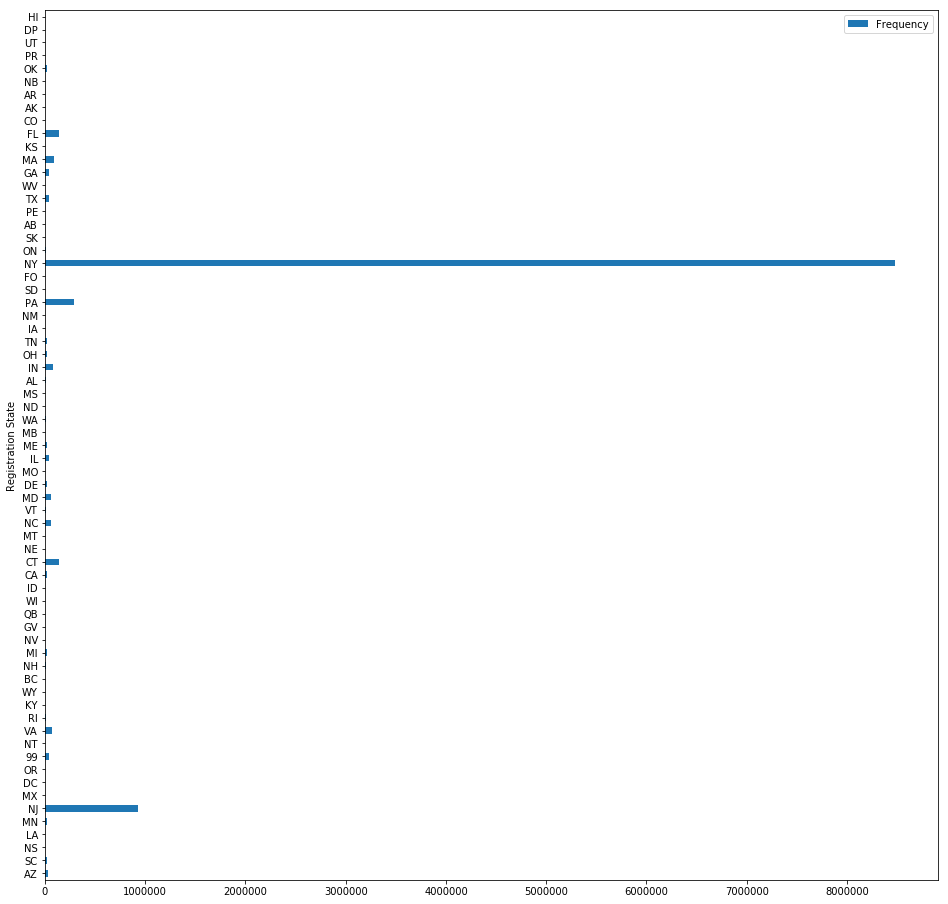

In [62]:
# Lets visualize ticket distribution w.r.t Registration State
ticket_dist = spark.sql("SELECT `Registration State`, count(*) as `Frequency` FROM parking_table GROUP BY `Registration State`")
plot = ticket_dist.toPandas().set_index('Registration State').plot.barh(figsize=(16, 16))

# Observations:
# 1. Maximum number of Tickets are from NY, which is far more than any other state
# 2. There is entry of "99" which is not a valid state

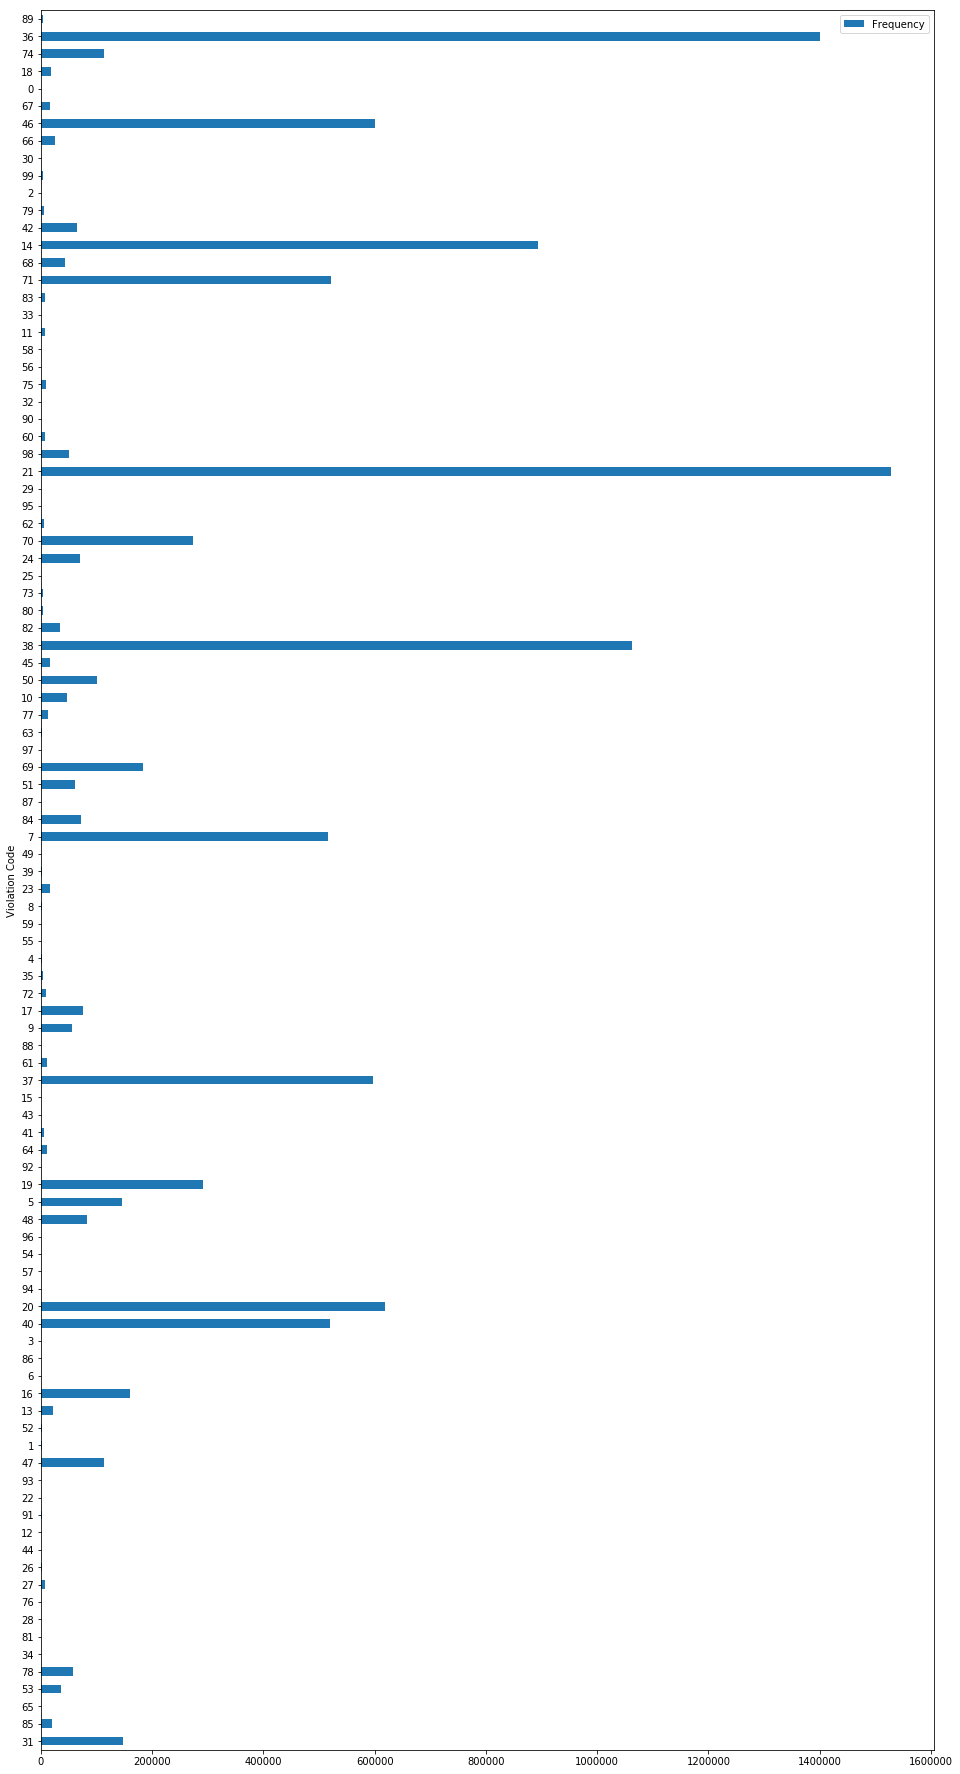

In [63]:
# Lets visualize ticket distribution w.r.t Violation Code
ticket_dist = spark.sql("SELECT `Violation Code`, count(*) as `Frequency` FROM parking_table GROUP BY `Violation Code`")
plot = ticket_dist.toPandas().set_index('Violation Code').plot.barh(figsize=(16, 32))

# Observations:
#  Max. number of tickets are with violation code 21, followed by 36 and 38

# Data Cleaning

In [64]:
# lets drop the null values and create a clean dataset
parking_clean = parking.na.drop()

In [65]:
from pyspark.sql.functions import count
from pyspark.sql.functions import countDistinct

# we will compare the cleaned dataset against the original ones and see if there are any null values
for cols in parking.columns:
    print("Lets compare Null values in column:",cols)
    print("Values from the original dataset:")
    parking.select(countDistinct(cols)).show()
    print("Values from the cleaned dataset:")
    parking_clean.select(countDistinct(cols)).show()
    print("*****************************************************************************")

Lets compare Null values in column: Summons Number
Values from the original dataset:
+------------------------------+
|count(DISTINCT Summons Number)|
+------------------------------+
|                      10803028|
+------------------------------+

Values from the cleaned dataset:
+------------------------------+
|count(DISTINCT Summons Number)|
+------------------------------+
|                      10803028|
+------------------------------+

*****************************************************************************
Lets compare Null values in column: Plate ID
Values from the original dataset:
+------------------------+
|count(DISTINCT Plate ID)|
+------------------------+
|                 3059046|
+------------------------+

Values from the cleaned dataset:
+------------------------+
|count(DISTINCT Plate ID)|
+------------------------+
|                 3059046|
+------------------------+

*****************************************************************************
Lets compa

In [66]:
# Observation: count of distinct values for all the columns are equal before and after dropping the null values, which means 
# there are no null values in the dataset

In [67]:
# lets drop duplicates
parking = parking.dropDuplicates()

# lets re-register the table
parking.createOrReplaceTempView("parking_table")

# Examine the Data

In [68]:
# Q1. Find the total number of tickets for the year.

# Total number of tickets for the year 2017
spark.sql("""SELECT Year(`Issue Date`), count(*) as `Tolal Tickets - 2017` FROM parking_table where Year(`Issue Date`) = 2017
GROUP BY Year(`Issue Date`)""").show()

+------------------------------+--------------------+
|year(CAST(Issue Date AS DATE))|Tolal Tickets - 2017|
+------------------------------+--------------------+
|                          2017|             5431918|
+------------------------------+--------------------+



In [69]:
# Q2. Find out the number of unique states from where the cars that got parking tickets came.

from pyspark.sql.functions import col, regexp_replace, udf, date_format

# no. of unique states
spark.sql("SELECT count(DISTINCT `Registration State`) as `States Count` FROM parking_table").show()
# there are 67 unique states

print("Following is the list of unique States from where the Cars came for parking::")
spark.sql("SELECT DISTINCT(`Registration State`) FROM parking_table").sort('Registration State').show()
# there seems to be an invalid entry here, 99, lets replace it with the state with maximum entries

print("Following is the count of the cars came for parking from each states")
ticket_distribution = spark.sql("""SELECT `Registration State`, count(*) as `States Count` FROM parking_table GROUP BY `Registration State`""").sort('States Count',ascending = False).show()
#  we can see NY state has maximum entries, we will replace 99 by NY

+------------+
|States Count|
+------------+
|          67|
+------------+

Following is the list of unique States from where the Cars came for parking::
+------------------+
|Registration State|
+------------------+
|                99|
|                AB|
|                AK|
|                AL|
|                AR|
|                AZ|
|                BC|
|                CA|
|                CO|
|                CT|
|                DC|
|                DE|
|                DP|
|                FL|
|                FO|
|                GA|
|                GV|
|                HI|
|                IA|
|                ID|
+------------------+
only showing top 20 rows

Following is the count of the cars came for parking from each states
+------------------+------------+
|Registration State|States Count|
+------------------+------------+
|                NY|     8481061|
|                NJ|      925965|
|                PA|      285419|
|                FL|      144556|
|        

In [70]:
# Q2. There is a numeric entry '99' in the column, which should be corrected. 
# Replace it with the state having the maximum entries. Provide the number of unique states again.

# Since state of NY had maximum entries, we will replace 99 by NY
parking = parking.withColumn('Registration State', regexp_replace('Registration State', '99', 'NY'))

# update the table view with the clean dataset
parking.createOrReplaceTempView("parking_table")

print("Following is the updated list of Unique States from where the Cars came for parking::")
ticket_distribution = spark.sql("""SELECT `Registration State`, count(*) as `State Count` FROM parking_table GROUP BY `Registration State`""").sort('Registration State').show()

# no. of unique states after fixing the invalid entry of 99
spark.sql("SELECT count(DISTINCT `Registration State`) as `States Count` FROM parking_table").show()
# So, we have 66 unique states after replacing the invalid entry with NY

Following is the updated list of Unique States from where the Cars came for parking::
+------------------+-----------+
|Registration State|State Count|
+------------------+-----------+
|                AB|        218|
|                AK|        754|
|                AL|       6891|
|                AR|       2621|
|                AZ|      26426|
|                BC|        127|
|                CA|      24260|
|                CO|       4093|
|                CT|     141088|
|                DC|       4250|
|                DE|      16325|
|                DP|       3192|
|                FL|     144556|
|                FO|         12|
|                GA|      36852|
|                GV|        704|
|                HI|        408|
|                IA|       4186|
|                ID|       2920|
|                IL|      37329|
+------------------+-----------+
only showing top 20 rows

+------------+
|States Count|
+------------+
|          66|
+------------+



# Aggregation tasks

In [71]:
# Q1. How often does each violation code occur? Display the frequency of the top five violation codes

# Solution: top 5 violation codes are : 21,36,38,14 and 20
spark.sql("SELECT `Violation Code`, count(*) as `Frequency` \
    FROM parking_table \
    GROUP BY `Violation Code` \
    ORDER BY `Frequency` DESC \
    LIMIT 5").show()

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|  1528588|
|            36|  1400614|
|            38|  1062304|
|            14|   893498|
|            20|   618593|
+--------------+---------+



In [72]:
# 2.1 How often does each 'vehicle body type' get a parking ticket?

#Solution: Please see the table below
spark.sql(
    "SELECT `Vehicle Body Type`, count(*) as `Frequency` \
    FROM parking_table \
    GROUP BY `Vehicle Body Type` \
    ORDER BY `Frequency` DESC \
    LIMIT 5").show()

+-----------------+---------+
|Vehicle Body Type|Frequency|
+-----------------+---------+
|             SUBN|  3719802|
|             4DSD|  3082020|
|              VAN|  1411970|
|             DELV|   687330|
|              SDN|   438191|
+-----------------+---------+



In [73]:
# 2.2: How about the 'vehicle make'?

#Solution: Please see the table below
spark.sql(
    "SELECT `Vehicle Make`, count(*) as `Frequency` \
    FROM parking_table \
    GROUP BY `Vehicle Make` \
    ORDER BY `Frequency` DESC \
    LIMIT 5").show()

+------------+---------+
|Vehicle Make|Frequency|
+------------+---------+
|        FORD|  1280958|
|       TOYOT|  1211451|
|       HONDA|  1079238|
|       NISSA|   918590|
|       CHEVR|   714655|
+------------+---------+



# Q3. A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following:

In [74]:
# Q3.1 'Violation Precinct' (This is the precinct of the zone where the violation occurred).
# Using this, can you draw any insights for parking violations in any specific areas of the city?

#Solution: Please see the table below
spark.sql(
    "SELECT `Violation Precinct`, count(*) as `Frequency` \
    FROM parking_table \
    GROUP BY `Violation Precinct` \
    ORDER BY `Frequency` DESC \
    LIMIT 6").show()

+------------------+---------+
|Violation Precinct|Frequency|
+------------------+---------+
|                 0|  2072400|
|                19|   535671|
|                14|   352450|
|                 1|   331810|
|                18|   306920|
|               114|   296514|
+------------------+---------+



In [75]:
# Q3.2 'Issuer Precinct' (This is the precinct that issued the ticket.)
# Here, you would have noticed that the dataframe has the'Violating Precinct' or 'Issuing Precinct' as '0'. 
# These are erroneous entries. Hence, you need to provide the records for five correct precincts. 
# (Hint: Print the top six entries after sorting.)

#Solution: Please see the table below
spark.sql(
    "SELECT `Issuer Precinct`, count(*) as `Frequency` \
    FROM parking_table \
    GROUP BY `Issuer Precinct` \
    ORDER BY `Frequency` DESC \
    LIMIT 6").show()

+---------------+---------+
|Issuer Precinct|Frequency|
+---------------+---------+
|              0|  2388479|
|             19|   521513|
|             14|   344977|
|              1|   321170|
|             18|   296553|
|            114|   289950|
+---------------+---------+



In [76]:
# Q4.1 Find the violation code frequencies for three precincts that have issued the most number of tickets. 

# From the solution of Q3, we saw that 19, 14, 1 were the top 3 precinct, we will write queries to find violation code
# for all the 3 identified precint

# Query for precinct 19
print("Violation Code & Number of tickets with that Violation Code for the Issuer Precinct = 19")
spark.sql(
    "SELECT `Violation Code`, count(*) as `Frequency` \
    FROM parking_table \
    WHERE `Issuer Precinct`= 19 \
    GROUP BY `Violation Code` \
    ORDER BY `Frequency` DESC \
    LIMIT 10").show()

# Query for precinct 14
print("Violation Code & Number of tickets with that Violation Code for the Issuer Precinct = 14")
spark.sql(
    "SELECT `Violation Code`, count(*) as `Frequency` \
    FROM parking_table \
    WHERE `Issuer Precinct`= 14 \
    GROUP BY `Violation Code` \
    ORDER BY `Frequency` DESC \
    LIMIT 10").show()

# Query for precinct 1
print("Violation Code & Number of tickets with that Violation Code for the Issuer Precinct = 1")
spark.sql(
    "SELECT `Violation Code`, count(*) as `Frequency` \
    FROM parking_table \
    WHERE `Issuer Precinct`= 1 \
    GROUP BY `Violation Code` \
    ORDER BY `Frequency` DESC \
    LIMIT 10").show()

Violation Code & Number of tickets with that Violation Code for the Issuer Precinct = 19
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            46|    86390|
|            37|    72437|
|            38|    72344|
|            14|    57563|
|            21|    54700|
|            16|    31353|
|            20|    27352|
|            40|    21513|
|            71|    15107|
|            19|    12896|
+--------------+---------+

Violation Code & Number of tickets with that Violation Code for the Issuer Precinct = 14
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            14|    73837|
|            69|    58026|
|            31|    39857|
|            47|    30540|
|            42|    20663|
|            46|    13435|
|            84|    11111|
|            19|    11062|
|            82|     8853|
|            17|     6160|
+--------------+---------+

Violation Code & Number of tickets with that Violation Code for 

In [77]:
# Q4.2 Do these precinct zones have an exceptionally high frequency of certain violation codes? 

# Answer 4.2:
# Frequency of the violation codes ranges from 12896 to 86390 for precinct zone = 19
# Frequency of the violation codes ranges from  6160 to 73837 for precinct zone = 14
# Frequency of the violation codes ranges from 10487 to 73522 for precinct zone = 1

# Conclusion: From above stats it is clear that certain violation codes have higher frequency than other violation codes

In [78]:
# Q4.3 Are these codes common across precincts? 

# Answer 4.3:
# Violation codes 14 & 46 are present in the top list of all the 3 Precinct zones
# Violation code  31 is present in precinct = 1 & 14
# Violation code  38 is present in precinct = 1 & 19

# Q5 Find out the properties of parking violations across different times of the day:

In [79]:
#5.1 Find a way to deal with missing values, if any.
# (Hint: Check for the null values using 'isNull' under the SQL. Also, to remove the null values, check the 'dropna' command in the API documentation.)

na_count = parking.where(
    col("Summons Number").isNull() | \
    col("Plate Id").isNull() | \
    col("Registration State").isNull() | \
    col("Issue Date").isNull() | \
    col("Violation Code").isNull() | \
    col("Vehicle Body Type").isNull() | \
    col("Vehicle Make").isNull() | \
    col("Violation Precinct").isNull() | \
    col("Issuer Precinct").isNull() | \
    col("Violation Time").isNull()
).count()

print(f'There are {na_count} null values in the Dataframe')

# Note: In the above query, we just checked whether there were any python identifiable null values in the dataset.
# we are yet to check if we have values like "NULL" "nan/NAN" or "BLANK" values in the dataset, lets check in the next query.

There are 0 null values in the Dataframe


In [80]:
# From the above check we came to know there are no null values in the dataset but there might be values like
# "NULL", "NAN" & "BLANK" which were not identified by python.
# lets try to identify such records
dropNullDF1 = parking.filter(col("Violation Time").isNull())
dropNullDF2 = parking.where("`Violation Time` == ''")
dropNullDF3 = parking.where((col("Violation Time") == "nan") | (col("Violation Time") == "Nan"))
dropNullDF1.select(countDistinct("Violation Time"), count("Violation Time")).show()
dropNullDF2.select(countDistinct("Violation Time"), count("Violation Time")).show()
dropNullDF3.select(countDistinct("Violation Time"), count("Violation Time")).show()

+------------------------------+---------------------+
|count(DISTINCT Violation Time)|count(Violation Time)|
+------------------------------+---------------------+
|                             0|                    0|
+------------------------------+---------------------+

+------------------------------+---------------------+
|count(DISTINCT Violation Time)|count(Violation Time)|
+------------------------------+---------------------+
|                             0|                    0|
+------------------------------+---------------------+

+------------------------------+---------------------+
|count(DISTINCT Violation Time)|count(Violation Time)|
+------------------------------+---------------------+
|                             1|                   63|
+------------------------------+---------------------+



In [81]:
# we can see there are 63 records where Violation Time had "nan/Nan" values, lets drop all such records

In [82]:
# filter the dataset, ignore records where violation time have nan/Nan values
parking = parking.filter((col("Violation Time") != "nan") & (col("Violation Time") != "Nan"))

# lets see how many distinct and total violation times values we have
parking.select(countDistinct("Violation Time"), count("Violation Time")).show()

# re-register the dataframe to the table
parking.createOrReplaceTempView("parking_table")

+------------------------------+---------------------+
|count(DISTINCT Violation Time)|count(Violation Time)|
+------------------------------+---------------------+
|                          1743|             10802965|
+------------------------------+---------------------+



In [83]:
# Q5.2 The Violation Time field is specified in a strange format. 
# Find a way to make this a time attribute that you can use to divide into groups.

# Lets find out all the count of records where Violation Time has invalid format
parking.select("Violation Time", col("Violation Time").rlike("^[01][0-9]{3}[AP]$").alias("criteria")).where(col("criteria")=="false").show()
parking.select("Violation Time", col("Violation Time").rlike("^[01][0-9]{3}[AP]$").alias("criteria")).where(col("criteria")=="false").count()

# lets impute proper values in the above records
parking = parking.withColumn('Violation Time', regexp_replace('Violation Time', '^.*[^0-9AP].*$', '0000A'))
parking = parking.withColumn('Violation Time', regexp_replace('Violation Time', '^.*[^AP]$', '0000A'))
parking = parking.withColumn('Violation Time', regexp_replace('Violation Time', '^[^01].*$', '0000A'))
parking = parking.withColumn('Violation Time', regexp_replace('Violation Time', '^[0-9AP]{1,4}$', '0000A'))

# lets convert Violation time to 24 Hours Format for easy binning
# Also handling many kinds of faulty entries like 13:00 AM or 13:00 PM // since given time must be in 12 hour format
maketime_udf_str_1 = udf(lambda x: x[0:2]+':'+x[2:4]+':00' if x[-1]=="A" or int(x[0:2]) in range(13,25) else str(int(x[0:2])+12)+':'+x[2:4]+':00', StringType())

# Make hour 24 as 00 for later conversion
maketime_udf_str_2 = udf(lambda x: '00'+x[2:] if x[0:2]=="24" else x, StringType())
parking = parking.withColumn('Violation Time Clean', maketime_udf_str_1('Violation Time'))
parking = parking.withColumn('Violation Time Clean', maketime_udf_str_2('Violation Time Clean'))
parking = parking.withColumn('Violation Time Formatted', date_format('Violation Time Clean', 'H:m:s'))

parking.printSchema()

+--------------+--------+
|Violation Time|criteria|
+--------------+--------+
|         3429P|   false|
|         2203P|   false|
|         5028P|   false|
|         115+A|   false|
|         3025P|   false|
|         7215P|   false|
|         5620P|   false|
|         7630P|   false|
|         4317P|   false|
|         2359P|   false|
|         5825P|   false|
|         8450P|   false|
|         8424P|   false|
|         09.5A|   false|
|         5857P|   false|
|         5616P|   false|
|         2908P|   false|
|         6815P|   false|
|         7311P|   false|
|         5936P|   false|
+--------------+--------+
only showing top 20 rows

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: i

In [84]:
# Lets Register the cleaned Dataset
parking.createOrReplaceTempView("parking_table")

# lets check how does the new violation time looks like
spark.sql('SELECT `Violation Time`, `Violation Time Clean`, `Violation Time Formatted` FROM parking_table').show(5)

+--------------+--------------------+------------------------+
|Violation Time|Violation Time Clean|Violation Time Formatted|
+--------------+--------------------+------------------------+
|         0100A|            01:00:00|                   1:0:0|
|         0100P|            13:00:00|                  13:0:0|
|         0100P|            13:00:00|                  13:0:0|
|         0100P|            13:00:00|                  13:0:0|
|         0101P|            13:01:00|                  13:1:0|
+--------------+--------------------+------------------------+
only showing top 5 rows



In [85]:
# Q5.3 Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. 

result = spark.sql(
    'SELECT `Violation Code`, count(*) as `Frequency`, \
    CASE \
    WHEN HOUR(`Violation Time Formatted`) IN ("0","1","2","3") THEN "00:00 - 03:59" \
    WHEN HOUR(`Violation Time Formatted`) IN ("4","5","6","7") THEN "04:00 - 07:59" \
    WHEN HOUR(`Violation Time Formatted`) IN ("8","9","10","11") THEN "08:00 - 11:59" \
    WHEN HOUR(`Violation Time Formatted`) IN ("12","13","14","15") THEN "12:00 - 15:59" \
    WHEN HOUR(`Violation Time Formatted`) IN ("16","17","18","19") THEN "16:00 - 19:59" \
    WHEN HOUR(`Violation Time Formatted`) IN ("20","21","22","23") THEN "20:00 - 23:59" \
    END AS `Violation Time Bin` \
    FROM parking_table \
    GROUP BY `Violation Time Bin`,`Violation Code`')

# Register the result dataset as a separate SQL view for further Analysis
result.createOrReplaceTempView("parking_table_temp")

In [86]:
# Q5.3 # For each of these groups, find the three most commonly occurring violations.

print('Violation Time Bin="00:00 - 03:59"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Time Bin` ="00:00 - 03:59" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()

print('Violation Time Bin="04:00 - 07:59"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Time Bin` ="04:00 - 07:59" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()

print('Violation Time Bin="08:00 - 11:59"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Time Bin` ="08:00 - 11:59" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()

print('Violation Time Bin="12:00 - 15:59"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Time Bin` ="12:00 - 15:59" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()

print('Violation Time Bin="16:00 - 19:59"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Time Bin` = "16:00 - 19:59" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()

print('Violation Time Bin="20:00 - 23:59"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Time Bin` = "20:00 - 23:59" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()

Violation Time Bin="00:00 - 03:59"
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   216890|
|            36|   211434|
|            38|   106871|
+--------------+---------+

Violation Time Bin="04:00 - 07:59"
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            14|   141275|
|            21|   119466|
|            40|   112186|
+--------------+---------+

Violation Time Bin="08:00 - 11:59"
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|  1182676|
|            36|   751422|
|            38|   346518|
+--------------+---------+

Violation Time Bin="12:00 - 15:59"
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            36|   376961|
|            38|   356354|
|            37|   265869|
+--------------+---------+

Violation Time Bin="16:00 - 19:59"
+--------------+---------+
|Violation Code|Frequency|
+----------

In [87]:
# Q5.4 Now, try another direction. For the three most commonly occurring violation codes, 
# find the most common time of the day (in terms of the bins from the previous part).

# Solution: 3 most commonly violation codes were 38, 21 and 36, below are the queries to find out Bin they belongs to

print('Violation Code=38')
spark.sql(
    'SELECT `Violation Time Bin`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Code` = 38 \
    ORDER BY `Frequency` DESC \
    LIMIT 1').show()

print('Violation Code=21')
spark.sql(
    'SELECT `Violation Time Bin`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Code` = 21 \
    ORDER BY `Frequency` DESC \
    LIMIT 1').show()

print('Violation Code=36')
spark.sql(
    'SELECT `Violation Time Bin`,  `Frequency`\
    FROM parking_table_temp \
    WHERE `Violation Code` = 36 \
    ORDER BY `Frequency` DESC \
    LIMIT 1').show()

Violation Code=38
+------------------+---------+
|Violation Time Bin|Frequency|
+------------------+---------+
|     12:00 - 15:59|   356354|
+------------------+---------+

Violation Code=21
+------------------+---------+
|Violation Time Bin|Frequency|
+------------------+---------+
|     08:00 - 11:59|  1182676|
+------------------+---------+

Violation Code=36
+------------------+---------+
|Violation Time Bin|Frequency|
+------------------+---------+
|     08:00 - 11:59|   751422|
+------------------+---------+



# Q6.Let’s try and find some seasonality in this data

In [88]:
# Q6.1 First, divide the year into a certain number of seasons, and find the frequencies of tickets for each season. 
# (Hint: Use Issue Date to segregate into seasons.)

# we will createa new dataset called result and will register it as a table in spark to analyse further
# we will break the months into seasons as follows:
# Dec/Jan/Feb = Winter
# Mar/Apr/May = Spring
# Jun/Jul/Aug = Summer
# Sep/Oct/Nov = Fall

result = spark.sql(
    'SELECT `Violation Code`, count(*) as `Frequency`, \
    CASE \
    WHEN MONTH(`Issue Date`) IN ("12","1","2") THEN "Winter" \
    WHEN MONTH(`Issue Date`) IN ("3","4","5") THEN "Spring" \
    WHEN MONTH(`Issue Date`) IN ("6","7","8") THEN "Summer" \
    WHEN MONTH(`Issue Date`) IN ("9","10","11") THEN "Fall" \
    END AS `season` \
    FROM parking_table \
    GROUP BY `season`,`Violation Code`')

# Register the result dataset as a separate SQL view for further Analysis
result.createOrReplaceTempView("parking_table_temp")

In [89]:
# Q6.2 Then, find the three most common violations for each of these seasons.

# Solution: 

# Frequency of violation codes for winter
print('season="Winter"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE season="Winter" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()


# Frequency of violation codes for Spring
print('season="Spring"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE season="Spring" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()

# Frequency of violation codes for Summer
print('season="Summer"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE season="Summer" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()


# Frequency of violation codes for Fall
print('season="Fall"')
spark.sql(
    'SELECT `Violation Code`,  `Frequency`\
    FROM parking_table_temp \
    WHERE season="Fall" \
    ORDER BY `Frequency` DESC \
    LIMIT 3').show()

season="Winter"
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   362341|
|            36|   359338|
|            38|   259723|
+--------------+---------+

season="Spring"
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   402807|
|            36|   344834|
|            38|   271192|
+--------------+---------+

season="Summer"
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   405961|
|            38|   247561|
|            36|   240396|
+--------------+---------+

season="Fall"
+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            36|   456046|
|            21|   357479|
|            38|   283828|
+--------------+---------+



# Q7. The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department.

In [90]:
#Q7.1 Find the total occurrences of the three most common violation codes.

#Solution:
top3vc = spark.sql("select `Violation Code`, count(*) as Frequency\
         from parking_table group by `Violation Code` order by Frequency desc limit 3")
top3vc.show()

# Answer: top 3 violation codes are 21,36 and 38

# register DataFrame as temp table, we will use this table for the rest of our analysis
top3vc.createOrReplaceTempView("violation_codes_table") 

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|  1528588|
|            36|  1400614|
|            38|  1062304|
+--------------+---------+



In [91]:
# Q7.2 Then, visit the website: http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
# It lists the fines associated with different violation codes. 
# They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. 

# from the website mentioned above, fine for violation codes are as given below:
# Violation-Code  Density   Fine     
#      21          High      65 
#      36          High      50 
#      38          High      65 
#      21          Low       45 
#      36          Low       50 
#      38          Low       35

# lets create two columns named "High_Density_Loc_Fine" for high density areas & "Rest_of_City_Fine" for other parts of the city
top3vc = spark.sql("SELECT *, \
                                CASE WHEN `Violation Code` == 21 \
                                THEN  65 \
                                WHEN `Violation Code` == 36 \
                                THEN 50 \
                                ELSE 65 \
                                END AS `High_Density_Loc_Fine`, \
                                CASE WHEN `Violation Code` == 21 \
                                THEN  45 \
                                WHEN `Violation Code` == 36 \
                                THEN 50 \
                                ELSE 35 \
                                END AS `Rest_of_City_Fine` \
                                FROM violation_codes_table")
top3vc.show(5)           

# update the SQL view to record the changes done to the dataframe
top3vc.createOrReplaceTempView("violation_codes_table")

#For the sake of simplicity, take the average of the two.
top3vc = spark.sql("SELECT *, \
                                 cast((`High_Density_Loc_Fine` + `Rest_of_City_Fine`)/2 as int) AS `Average Fine` \
                                FROM violation_codes_table")
top3vc.show(5)      

# update the SQL view to record the changes done to the dataframe
top3vc.createOrReplaceTempView("violation_codes_table")

+--------------+---------+---------------------+-----------------+
|Violation Code|Frequency|High_Density_Loc_Fine|Rest_of_City_Fine|
+--------------+---------+---------------------+-----------------+
|            21|  1528588|                   65|               45|
|            36|  1400614|                   50|               50|
|            38|  1062304|                   65|               35|
+--------------+---------+---------------------+-----------------+

+--------------+---------+---------------------+-----------------+------------+
|Violation Code|Frequency|High_Density_Loc_Fine|Rest_of_City_Fine|Average Fine|
+--------------+---------+---------------------+-----------------+------------+
|            21|  1528588|                   65|               45|          55|
|            36|  1400614|                   50|               50|          50|
|            38|  1062304|                   65|               35|          50|
+--------------+---------+---------------------+--

In [92]:
# Q7.3.1 Using this information, find the total amount collected for the three violation codes with the maximum tickets. 
spark.sql("SELECT *, `Average Fine` * Frequency as `Total Fine` FROM violation_codes_table").show()

#Q7.3.2 State the code that has the highest total collection.
# Answer: Violation code 21 has the highest collection

+--------------+---------+---------------------+-----------------+------------+----------+
|Violation Code|Frequency|High_Density_Loc_Fine|Rest_of_City_Fine|Average Fine|Total Fine|
+--------------+---------+---------------------+-----------------+------------+----------+
|            21|  1528588|                   65|               45|          55|  84072340|
|            36|  1400614|                   50|               50|          50|  70030700|
|            38|  1062304|                   65|               35|          50|  53115200|
+--------------+---------+---------------------+-----------------+------------+----------+



In [93]:
# Q7.4 We can intuitively infer the following from these findings:

# Answer:
# 1. Violation Code = 21 means No parking where parking is not allowed by sign, street marking or traffic control device.
# 2. Violation Code = 36 means Parking in a meter space for the purpose of displaying, selling, storing, or offering goods 
#    for sale.
#    Getting highest collection from code 21 & 36 means people are either ignoring the sign boards/meter spaces
#    or they are parking thier cars these areas because they could not find parking anywhere else.

In [94]:
# Closing the Spark session
spark.stop()